In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

KFOLD_SEED = 42

In [2]:
input_path = '~/data/biddings.csv'
data = pd.read_csv(input_path)
print(data.shape)

(1000000, 89)


In [3]:
train = data[:800000]
test = data[800000:]

sample = train.sample(frac=1)
features = sample.drop('convert', axis=1).values
labels = sample.convert.ravel()

test_features = test.drop('convert', axis=1).values
test_labels = test.convert.ravel()

### Explore input data

Only ~0.2% of rows have `convert = true`

In [8]:
pd.value_counts(data['convert'])[1]/data.shape[0] * 100

0.1908

#### Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

Cross validation with mean accuracy as test metric

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split

def test_auc(model):
    predicted_scores = model.predict_proba(test_features)[:,1]
    fpr, tpr, thresholds = roc_curve(test_labels, predicted_scores)
    return auc(fpr, tpr)


def train_kfold(classifier, features, labels, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=KFOLD_SEED)
    
    fprs = []
    tprs = []
    aucs = []
    test_aucs = []
    
    for train_index, validation_index in kf.split(features):
        train_features, validation_features = features[train_index], features[validation_index]
        train_labels, validation_labels = labels[train_index], labels[validation_index]

        model = classifier.fit(train_features, train_labels)
        predicted_scores = model.predict_proba(validation_features)[:,1]
        
        fpr, tpr, thresholds = roc_curve(validation_labels, predicted_scores)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc(fpr, tpr))
        test_aucs.append(test_auc(model))
    
    return fprs, tprs, np.mean(aucs), np.mean(test_aucs)


We use ROC_AUC (Receiver operating characteristic area under curve) as the main metric rather than accuracy because the label distribution is highly unbalanced. But since we are using under-sampled data here, we should look at accuracy as well.

#### Establish baseline

In [116]:
lr = LogisticRegression(penalty='l2')
fprs, tprs, mean_valid_auc, mean_test_auc = train_kfold(lr, features, labels, n_splits=3)
print("validation_auc: %0.3f, test_auc: %0.3f" % (mean_valid_auc, mean_test_auc))


validation_auc: 0.684, test_auc: 0.711


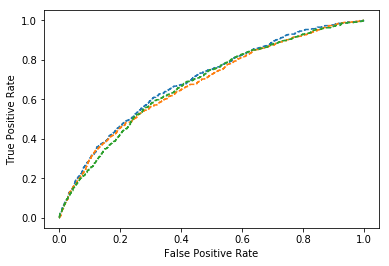

In [117]:
for i in range(3):
    plt.plot(fprs[i], tprs[i], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
    

#### Examine feature variance

In [8]:
from sklearn.feature_selection import VarianceThreshold

def get_selector(features, threshold=0.8):
    selector = VarianceThreshold(threshold)
    selector.fit(features)
    return selector
#     print("Variances is %s"%selector.variances_)
#     print("After transform is %s"%selector.transform(features))
#     print("The support is %s"%selector.get_support(True))

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

selector = get_selector(features, threshold=0.1)
lr = LogisticRegression(penalty='l1', verbose=1, random_state=KFOLD_SEED)

tree_selector = SelectFromModel(DecisionTreeClassifier(max_features=10))
print("created tree selector")

# tree_selector.fit(features, labels)
clf = Pipeline([
  ('feature_selection', tree_selector),
  ('classification', lr)
])

randomUnderSampler = RandomUnderSampler(ratio={0: 1531*8, 1: 1531}, random_state=KFOLD_SEED)
smote = SMOTE(n_jobs=-1, ratio={0:1531*8, 1:1531*4}, random_state=KFOLD_SEED)
undersampled_train_valid_features, undersampled_train_valid_labels = randomUnderSampler.fit_sample(
    features, labels)

# fprs, tprs, mean_valid_auc, mean_test_auc = over_down_sample_kfold(
#     clf, randomUnderSampler, undersampled_train_valid_features, undersampled_train_valid_labels)

fprs, tprs, mean_valid_auc, mean_test_auc = train_kfold(clf, features, labels, n_splits=3)
print("validation_auc: %0.3f, test_auc: %0.3f" % (mean_valid_auc, mean_test_auc))

created tree selector
[LibLinear][LibLinear][LibLinear]validation_auc: 0.669, test_auc: 0.691


In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(features)
svc = SVC(kernel='rbf', probability=True, max_iter=16, verbose=True)

fprs, tprs, mean_valid_auc, mean_test_auc = train_kfold(svc, scaler.transform(features), labels, n_splits=3)
print("validation_auc: %0.3f, test_auc: %0.3f" % (mean_valid_auc, mean_test_auc))

[LibSVM]

/root/.local/share/virtualenvs/RTB-V2Lvgo6A/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM][LibSVM]validation_auc: 0.482, test_auc: 0.479


#### Over/Down sampling


In [11]:
lr = LogisticRegression(penalty='l2')

def over_down_sample_kfold(classifier, sampler, features, labels, test_size=0.33):
    resampled_train_valid_features, resampled_train_valid_labels = sampler.fit_sample(
        features, labels)

    fprs, tprs, mean_valid_auc, mean_test_auc = train_kfold(classifier,
        resampled_train_valid_features, resampled_train_valid_labels, n_splits=3)
    
    print("%s, validation_auc: %0.3f, test_auc: %0.3f" % (
        sampler.__class__.__name__, mean_valid_auc, mean_test_auc))
    
    return fprs, tprs, mean_valid_auc, mean_test_auc
    

We don't want to use `NearMiss` as it overfits

In [7]:
# Down sampling
randomUnderSampler = RandomUnderSampler()
nearMiss = NearMiss(n_jobs=-1)
# Over sampling
# SMOTE is extremely slow due to large negative sample size
# smote = SMOTE(n_jobs=-1)
# randomOversampler = RandomOverSampler()

for sampler in [randomUnderSampler, nearMiss]:
    lr = LogisticRegression(penalty='l2')
    over_down_sample_kfold(lr, sampler, features, labels)


RandomUnderSampler, validation_auc: 0.684, test_auc: 0.699
NearMiss, validation_auc: 0.987, test_auc: 0.575


In [57]:
randomUnderSampler = RandomUnderSampler(ratio={0: 1531*20, 1: 1531}, random_state=KFOLD_SEED)
lr = LogisticRegression(penalty='l2')
over_down_sample_kfold(lr, randomUnderSampler, features, labels)

RandomUnderSampler, validation_auc: 0.684, test_auc: 0.710


([array([0.00000000e+00, 9.77899472e-05, 4.88949736e-04, ...,
         9.98728731e-01, 9.98728731e-01, 1.00000000e+00]),
  array([0.00000000e+00, 9.79144228e-05, 5.87486537e-04, ...,
         9.97258396e-01, 9.97454225e-01, 1.00000000e+00]),
  array([0.00000000e+00, 9.82221786e-05, 3.92888714e-04, ...,
         9.99901778e-01, 9.99901778e-01, 1.00000000e+00])],
 [array([0.        , 0.        , 0.        , ..., 0.99796334, 1.        ,
         1.        ]),
  array([0., 0., 0., ..., 1., 1., 1.]),
  array([0.        , 0.        , 0.        , ..., 0.99813433, 1.        ,
         1.        ])],
 0.6836825824150591,
 0.7102402684232191)

In [103]:
randomUnderSampler = RandomUnderSampler(ratio={0: 1531*4, 1: 1531}, random_state=KFOLD_SEED)

smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)
undersampled_train_valid_features, undersampled_train_valid_labels = randomUnderSampler.fit_sample(
    features, labels)

lr = LogisticRegression(penalty='l2', random_state=KFOLD_SEED)
over_down_sample_kfold(lr, smote, undersampled_train_valid_features, undersampled_train_valid_labels)


SMOTE, validation_auc: 0.698, test_auc: 0.717


([array([0.        , 0.        , 0.00143747, ..., 0.99952084, 0.99952084,
         1.        ]),
  array([0.0000000e+00, 0.0000000e+00, 4.8947626e-04, ..., 9.8825257e-01,
         9.8825257e-01, 1.0000000e+00]),
  array([0.00000000e+00, 0.00000000e+00, 5.01504514e-04, ...,
         9.88966901e-01, 9.89969910e-01, 1.00000000e+00])],
 [array([5.01002004e-04, 1.00200401e-03, 1.00200401e-03, ...,
         9.99498998e-01, 1.00000000e+00, 1.00000000e+00]),
  array([4.90196078e-04, 1.47058824e-03, 1.47058824e-03, ...,
         9.99509804e-01, 1.00000000e+00, 1.00000000e+00]),
  array([4.78927203e-04, 3.83141762e-03, 3.83141762e-03, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 0.6975238336852714,
 0.7174952127820182)

In [203]:
def custom_sampling():
    randomUnderSampler = RandomUnderSampler(ratio={0: 1531*4, 1: 1531}, random_state=KFOLD_SEED)

    smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)
    X, y = randomUnderSampler.fit_sample(features, labels)
    X2, y2 = smote.fit_sample(X, y)
    return X2, y2

def sgd_benchmark():
    sgd = SGDClassifier(random_state=KFOLD_SEED,
                        loss='log', penalty='l2', eta0=0.001, learning_rate='invscaling', max_iter=128)
    
    param_grid = {'eta0':[0.0001, 0.001, 0.01, 0.1],
                  'alpha': [0.0001, 0.001, 0.01],
                  'class_weight': [None, 'balanced', {0: 0.2, 1: 0.8}, {0: 0.6, 1: 0.4}, {0: 0.8, 1: 0.2}],
                  'power_t': [0.2, 0.5, 0.8],
                  'max_iter': [64, 128, 256]}
    
    gs = GridSearchCV(estimator=sgd, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
    X, y = custom_sampling()
    gs = gs.fit(X, y)
    
    return gs.best_score_, gs.best_params_

sgd_benchmark()

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64,

[CV]  alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5 


[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8 
[CV]  alph

[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.0001, 

[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, et

[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.

[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 

[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight

[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0

[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0

[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 

[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 

[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, 

[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, 

[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight

[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight

[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, m

[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, et

[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.5, total=   0.9s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.

[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.3s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight={0:

[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_

[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_i

[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.

[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=

[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5

[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, clas

[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=

[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=1

[CV]  alpha=0.01, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max

[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.8, total=   0.5s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2, total=   0.9s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2, total=   1.0s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2, total=   0.9s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0

[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power

[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8, total=   1.0s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0

[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_i

[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta

[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0

[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=256, po

[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 12.3min finished


(0.6972139198282097,
 {'alpha': 0.0001,
  'class_weight': {0: 0.2, 1: 0.8},
  'eta0': 0.01,
  'max_iter': 128,
  'power_t': 0.5})

In [206]:
sgd = SGDClassifier(loss='log', penalty='l2', random_state=KFOLD_SEED,
                    eta0=0.01, learning_rate='invscaling', max_iter=128, alpha=0.0001, power_t=0.5)

over_down_sample_kfold(sgd, smote, undersampled_train_valid_features, undersampled_train_valid_labels)

SMOTE, validation_auc: 0.696, test_auc: 0.717


([array([0.00000000e+00, 4.79156684e-04, 4.79156684e-04, ...,
         9.90416866e-01, 9.90416866e-01, 1.00000000e+00]),
  array([0.00000000e+00, 0.00000000e+00, 4.89476260e-04, ...,
         9.81889378e-01, 9.81889378e-01, 1.00000000e+00]),
  array([0.00000000e+00, 5.01504514e-04, 5.01504514e-04, ...,
         9.94483450e-01, 9.95486459e-01, 1.00000000e+00])],
 [array([0.00000000e+00, 0.00000000e+00, 5.01002004e-04, ...,
         9.99498998e-01, 1.00000000e+00, 1.00000000e+00]),
  array([4.90196078e-04, 5.88235294e-03, 5.88235294e-03, ...,
         9.99509804e-01, 1.00000000e+00, 1.00000000e+00]),
  array([0.00000000e+00, 0.00000000e+00, 9.57854406e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 0.6958160744686609,
 0.7171340058237895)

## Neural Net

In [8]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 2
epochs = 1

# convert class vectors to binary class matrices
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.33)

print(y_train.shape, test_labels.shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

test_labels = keras.utils.to_categorical(test_labels, num_classes)
print(y_train.shape, test_labels.shape)


Using TensorFlow backend.


(536000,) (200000,)
(536000, 2) (200000, 2)


In [9]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras.backend as K

def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N

# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

def custom_metric_roc_auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

model = Sequential()
model.add(Dense(2, activation='softmax', input_shape=(88,)))
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=[custom_metric_roc_auc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 178       
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 536000 samples, validate on 264000 samples
Epoch 1/1
536000/536000 [==============================] - 293s 546us/step - loss: 0.1162 - custom_metric_roc_auc: 0.9822 - val_loss: 0.0152 - val_custom_metric_roc_auc: 0.9980


In [298]:
print(X_train.shape, y_train.shape, test_features.shape, test_labels.shape)
score = model.evaluate(test_features, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test ROC_AUC:', score[1])

(536000, 88) (536000, 2) (200000, 88) (200000, 2)
200000/200000 [==============================] - 127s 636us/step
Test loss: 0.016618429867103695
Test ROC_AUC: 0.9974175
